# Analysing results for general experiment (series of n)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
experiment_id = "full_run"
filename_results = f"results_experiment_{experiment_id}.json"

df_results = pd.read_json(f"../data/{filename_results}")
# df_results.loc[df_results["status"].isnull(), "status"] = "Optimal"

In [3]:
df_results.head()

,experiment_id,tindar_id,n,connectedness,p,solver,status,objective_value,time
0,full_run,0,10,1,0.05,heuristic,Solved (optimal unsure),0,0.005080
1,full_run,1,10,1,0.05,heuristic,Solved (optimal unsure),0,0.002702
2,full_run,2,10,1,0.05,heuristic,Solved (optimal unsure),0,0.002947
3,full_run,3,10,1,0.05,heuristic,Solved (optimal unsure),0,0.000707
4,full_run,4,10,1,0.05,heuristic,Solved (optimal unsure),0,0.000811


## Data Validation

In [4]:
num_solvers = len(df_results["solver"].unique())

if num_solvers == 1:
    assert (df_results["tindar_id"].value_counts() == 1).all()

elif num_solvers == 2:
    assert (df_results["tindar_id"].value_counts() == 2).all()

else:
    raise Exception(f"Data says {num_solvers} solvers. Only 1 or 2 allowed")



## Objective value: difference pulp & heuristic

In [5]:
def solver_difference(df_sub):
    opt = df_sub.loc[df_sub["solver"] == "pulp"]
    heur = df_sub.loc[df_sub["solver"] == "heuristic"]
    
    opt_obj = opt["objective_value"].values[0]
    heur_obj = heur["objective_value"].values[0]

    opt_solvetime = opt["time"].values[0]
    heur_solvetime = heur["time"].values[0]
    
    if opt_obj == 0:
        perc_difference = 0
    else:
        perc_difference = (opt_obj - heur_obj)/opt_obj
    
    return pd.Series({
        "objective_difference_abs": opt_obj - heur_obj,
        "objective_difference_perc": perc_difference,
        "solvetime_difference_abs": opt_solvetime - heur_solvetime,
        "solvetime_difference_perc": (opt_solvetime - heur_solvetime)/heur_solvetime,
        "n": df_sub["n"].values[0],
        "connectedness": df_sub["connectedness"].values[0],
    })

df_solver_difference = df_results.groupby(["tindar_id"]).apply(solver_difference)
df_solver_difference.head()

,objective_difference_abs,objective_difference_perc,solvetime_difference_abs,solvetime_difference_perc,n,connectedness
tindar_id,,,,,,
0,0.0,0.0,0.083629,16.463374,10.0,1.0
1,0.0,0.0,0.083444,30.888136,10.0,1.0
2,0.0,0.0,0.085213,28.912123,10.0,1.0
3,0.0,0.0,0.092220,130.511746,10.0,1.0
4,0.0,0.0,0.080389,99.098866,10.0,1.0


## statistics

In [6]:
var = "time"
df_results.groupby(["solver", "n"]).apply(lambda x: x[var].mean())

solver     n  
heuristic  10      0.001935
           30      0.003719
           50      0.003744
           100     0.013841
           200     0.041946
           300     0.081234
           500     0.185418
pulp       10      0.087365
           30      0.272900
           50      0.658949
           100     2.638844
           200    10.772245
           300    22.164734
           500    43.719597
dtype: float64

In [7]:
var = "solvetime_difference_abs"
df_solver_difference.groupby("n").apply(lambda x: x[var].mean())

n
10.0      0.085431
30.0      0.269181
50.0      0.655205
100.0     2.625003
200.0    10.730299
300.0    22.083500
500.0    43.534179
dtype: float64

## visualizations

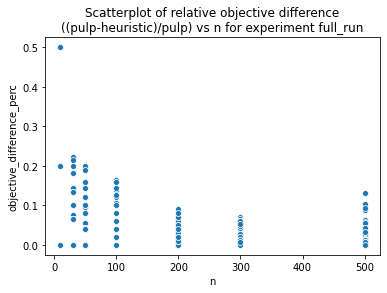

In [8]:
var_x = "n"
var_y = "objective_difference_perc"

plt.figure()
plt.title(f"Scatterplot of relative objective difference\n((pulp-heuristic)/pulp) vs {var_x} for experiment {experiment_id}")
sns.scatterplot(
    x = var_x,
    y = var_y,
    data = df_solver_difference
)
plt.savefig(f"../documentation/figures/scatterplot_{var_x}_vs_{var_y}_experiment_{experiment_id}")


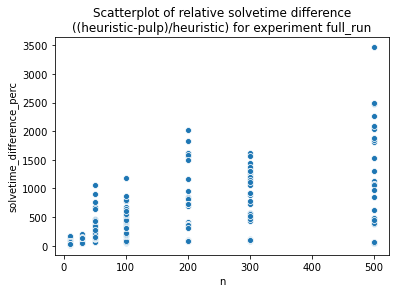

In [9]:
var_y = "solvetime_difference_perc"

plt.figure()
plt.title(f"Scatterplot of relative solvetime difference\n((heuristic-pulp)/heuristic) for experiment {experiment_id}")
sns.scatterplot(
    x = var_x,
    y = var_y,
    data = df_solver_difference
)
plt.savefig(f"../documentation/figures/scatterplot_{var_x}_vs_{var_y}_experiment_{experiment_id}")


### Heatmaps for targets vs(n, connectedness)

objective_difference_perc


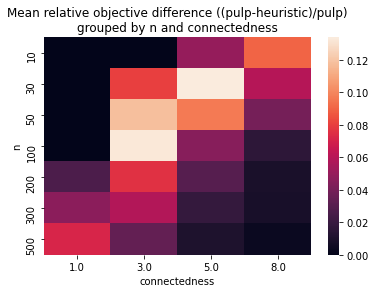

In [10]:
var_y = "objective_difference_perc"
print(var_y)
df_n_conn = df_solver_difference.groupby(["n", "connectedness"]).apply(lambda x: x[var_y].mean()).reset_index()
df_n_conn["n"] = df_n_conn["n"].astype(int)
df_n_conn.columns = list(df_n_conn.columns[:2]) + [var_y]
df_pivot = df_n_conn.pivot("n", "connectedness", var_y)

plt.figure()
plt.title(f"Mean relative objective difference ((pulp-heuristic)/pulp)\ngrouped by n and connectedness")
sns.heatmap(df_pivot)
plt.savefig(f"../documentation/figures/heatmap_{var_y}_experiment_{experiment_id}")


solvetime_difference_perc


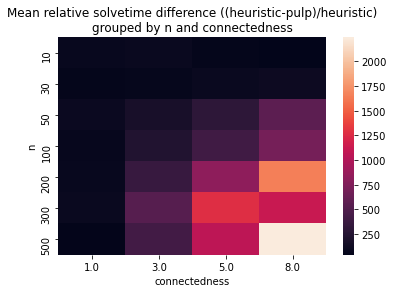

In [11]:
var_y = "solvetime_difference_perc"
print(var_y)
df_n_conn = df_solver_difference.groupby(["n", "connectedness"]).apply(lambda x: x[var_y].mean()).reset_index()
df_n_conn["n"] = df_n_conn["n"].astype(int)
df_n_conn.columns = list(df_n_conn.columns[:2]) + [var_y]
df_pivot = df_n_conn.pivot("n", "connectedness", var_y)

plt.figure()
plt.title(f"Mean relative solvetime difference ((heuristic-pulp)/heuristic)\ngrouped by n and connectedness")
sns.heatmap(df_pivot)
plt.savefig(f"../documentation/figures/heatmap_{var_y}_experiment_{experiment_id}")
